In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sb
import scipy.stats as stats
import scipy
print (scipy.__version__)

1.8.0


# **Dataset Amazon Top 50 Bestselling Books 2009 - 2022**
# **Come ha influito la pandemia sulla vendita di libri?**

Il dataset contiene i 50 libri best seller per anno dal 2009 al 2022

In questo notebook studieremo gli effetti che la pandemia ha avuto sulla vendita di libri su amazon, utilizzando quindi i bestseller

Il notebook è strutturato in tre punti principali:
+ numero di reviews prima e dopo il 2020
+ il genere preferito dall'utenza prima e dopo
+ la variazione del prezzo 

Per prima cosa facciamo qualche operazione preliminare per conoscere meglio il dataset:

In [2]:
book = pd.read_csv('bestsellers.csv') 
book.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17,2009,Non Fiction
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5,2009,Non Fiction
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13,2009,Fiction
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2009,Non Fiction
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4,2009,Fiction


Da una lettura preliminare del dataset attraverso la funzione head possiamo già capire che si potrà lavorare ad esempio sul campo "genre" che assume solo due tipi (fiction e non fiction) e capirne la correlazione con gli anni, le valutazioni ecc. ecc.

Estraiamo informazioni di base sul nostro dataset.

In [3]:
book.describe()

,User Rating,Reviews,Price,Year
count,700.000000,700.000000,700.000000,700.000000
mean,4.639857,19255.195714,12.700000,2015.500000
std,0.218586,23613.443875,9.915162,4.034011
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4987.250000,7.000000,2012.000000
50%,4.700000,10284.000000,11.000000,2015.500000
75%,4.800000,23358.000000,15.000000,2019.000000
max,4.900000,208917.000000,105.000000,2022.000000


Controllo se ci sono colonne con elementi vuoti, come vedremo non ci sono e quindi non dovrò eseguire funzioni di riempimento automatico

In [4]:
book.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

quanti dati e quante caratteristiche abbiamo a disposizione?

In [5]:
book.shape

(700, 7)

Dall'output della funzione shape capiamo che le colonne sono 7 (informazione già conosciuta) e che il numero di righe e cioè libri nel dataset è 700

Tutte le caratteristiche sono abbastanza significative tolte quelle qualitative come il nome e l'autore (che però non sono completamente inutili) e quindi non credo sia necessario eliminare delle colonne

Tuttavia sono presenti numerosi libri duplicati nel nostro dataset, forse per il fatto che un libro è stato bestseller per più anni o forse perchè il dataset è stato riempito automaticamente

In [6]:
#TODO

Adesso calcoliamo la correlazione

In [7]:
book.corr(method='pearson')

,User Rating,Reviews,Price,Year
User Rating,1.000000,0.080423,-0.157253,0.286601
Reviews,0.080423,1.000000,-0.114554,0.494279
Price,-0.157253,-0.114554,1.000000,-0.155266
Year,0.286601,0.494279,-0.155266,1.000000


La correlazione tra dati che si nota maggiormente è quella Reviewes - Year e quella User Rating - Year.

## REVIEWS NEGLI ANNI

Applicando un semplice grafico lineare si può vedere come proprio tra il 2019 e il 2020 c'è stato un vertiginoso inalzamento delle reviews

In [8]:
annual_reviews = book.groupby('Year')[['Reviews']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_reviews)

    Year   Reviews
0   2009   4710.12
1   2010   5479.62
2   2011   8100.82
3   2012  13090.92
4   2013  13098.14
5   2014  15859.94
6   2015  14233.38
7   2016  14196.00
8   2017  12888.40
9   2018  13930.42
10  2019  15898.34
11  2020  52349.94
12  2021  44859.48
13  2022  40877.22


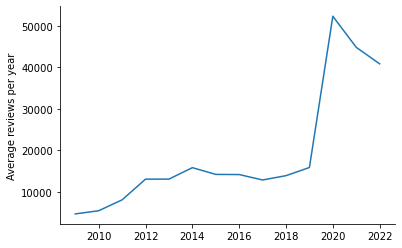

In [9]:
fig, ax = plt.subplots()
plt.plot(annual_reviews['Year'], annual_reviews['Reviews'])
plt.ylabel('Average reviews per year')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

<AxesSubplot:xlabel='Year', ylabel='Reviews'>

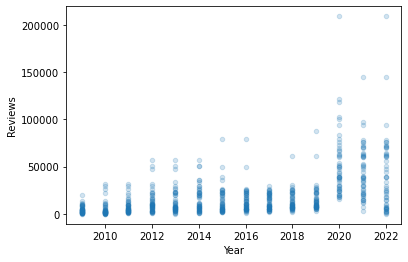

In [10]:
book.plot(kind= 'scatter', x= 'Year', y= 'Reviews', alpha= 0.2)

Questo è un chiaro esempio di come la pandemia ha effettivamente cambiato le abitudini.

A partire infatti dal 2020 c'è un aumento vertiginoso del numero di reviews, che può anche essere legato al numero di copie comprate (dato non presente purtroppo nel dataset)

Come possiamo vedere nel 2019 il numero medio di reviews si aggira attorno alle 16000 mentre nel 2020 il numero medio è 52000

Questo aumento è così improvviso e corposo non può essere ignorato, e deve essere sicuramente collegato ad un evento d'impatto come la pandemia.

Come possiamo immaginare essendo i best-seller degli ultimi anni il grafico mostra che la maggior parte delle valutazioni si avvicinano alle 5 stelle mentre quelle da 2 o 3 stelle sono davvero poche se non inesistenti

## STUDIO SUL GENERE PREFERITO

Le abitudini dei lettori sono cambiate con la pandemia? Anche se i dati sono un po' vaghi(distinzione solo tra Fiction e Non Fiction) possiamo vedere se le preferenze nei bestseller sono cambiate

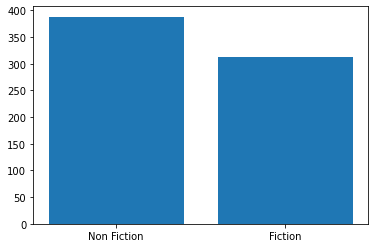

In [11]:
counts = book["Genre"].value_counts()
plt.bar(counts.index,counts.values)
plt.show()

Come possiamo vedere dal grafico c'è una predominanza (anche se leggera) sul genere "Non Fiction" rispetto a quello fiction in generale

([<matplotlib.patches.Wedge at 0x7f9f6abf07c0>,
 [Text(-0.1866898666921769, 1.0840419243158714, 'Fiction'),
  Text(0.18668986669217674, -1.0840419243158714, 'Non Fiction')],
 [Text(-0.10183083637755103, 0.5912955950813843, '55.4%'),
  Text(0.10183083637755094, -0.5912955950813843, '44.6%')])

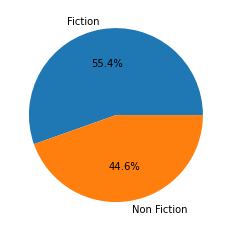

In [12]:
plt.pie(book['Genre'].value_counts(),labels=['Fiction','Non Fiction'],autopct='%.1f%%')

[Text(0.5, 1.0, 'genre distribution')]

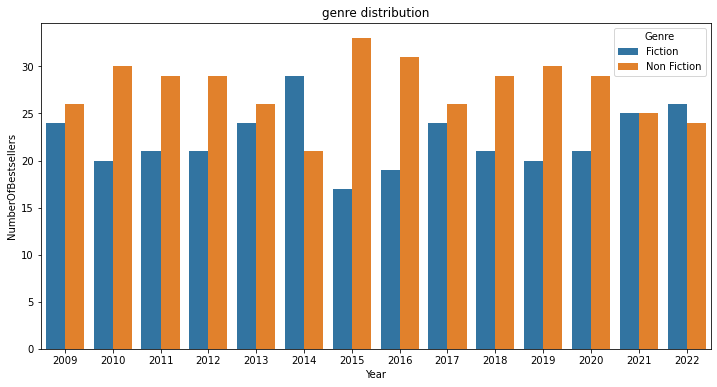

In [13]:
df=book.groupby(['Genre', 'Year']).size().reset_index(name='NumberOfBestsellers')
plt.figure(figsize=(12, 6))
sb.barplot(x='Year', y='NumberOfBestsellers', hue='Genre', data=df).set(title='genre distribution')

Attraverso la libreria seaborn possiamo vedere come c'è una distribuzione abbastanza casuale dei due generi anche se quello "non fiction" predomina quasi sempre

Negli ultimi anni c'è stata una "risalita" del genere "fiction" ma non è per forza collegato alla pandemia visto che anche in altri anni (2014) c'era stata una predominanza dei libri "fiction"

In [14]:
book.groupby('Genre')[['Reviews']].mean().reset_index()

,Genre,Reviews
0,Fiction,24034.105769
1,Non Fiction,15412.360825


Il numero di reviews medio è nettamente maggiore e come già detto in precedenza questo potrebbe essere strettamente collegato al numero di copie vendute.
Potrebbero quindi esserci un numero minore di bestseller di tipo fiction ma con più copie vendute 

In [15]:
book.groupby('Genre')[['User Rating']].mean().reset_index()

,Genre,User Rating
0,Fiction,4.664103
1,Non Fiction,4.620361


Senza l'utilizzo di un grafico possiamo vedere lo user rating è pressochè uguale quindi poco significativo

T-test su differenza rating in base al genere
Let's form our hypothesis:

+ H0: There are no significant differences in rating between different genres
+ H1: Different genres have significant different ratings

In [16]:
t_statistic, p_value = stats.ttest_1samp(a= book['User Rating'][book['Genre']=="Fiction"], popmean= book['User Rating'][book['Genre']!="Fiction"].mean(),alternative='less')
print(t_statistic)
print(p_value)

3.0653679551757302
0.9988176846248612


//TODO

## IL PREZZO

Un altro interessante studio che si può fare è quello sul prezzo: è aumentato negli anni? è diminuito? il genere incide sul prezzo del libro?

In [17]:
annual_price = book.groupby('Year')[['Price']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_price)

    Year  Price
0   2009  15.40
1   2010  13.48
2   2011  15.10
3   2012  15.30
4   2013  14.60
5   2014  14.64
6   2015  10.42
7   2016  13.18
8   2017  11.38
9   2018  10.52
10  2019  10.08
11  2020  10.46
12  2021  10.78
13  2022  12.46


Non sembra esserci stato un aumento significativo dei prezzi medi con l'avvento del covid

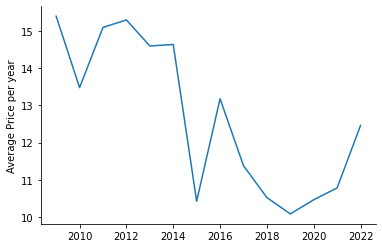

In [18]:
fig, ax = plt.subplots()
plt.plot(annual_price['Year'], annual_price['Price'])
plt.ylabel('Average Price per year')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Come si nota dal grafico il prezzo è molto variabile ma c'è una tendenza ad un prezzo più alto dal 2009 al 2014
Ora guardiamo se la variazione del costo in base al genere è significativa

<AxesSubplot:title={'center':'Price'}, xlabel='Year'>

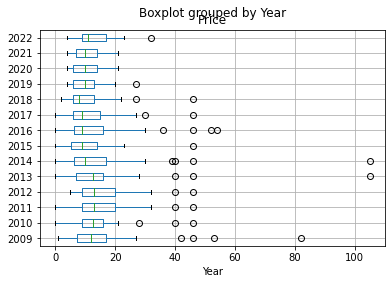

In [19]:
book.boxplot(column='Price', by='Year', vert = False)

Utilizzando anche un grafico boxplot vediamo come il range di prezzo è maggiore dal 2009 al 2014 per poi stabilizzarsi senza avere gap di prezzo troppo elevati

Una volta fatte queste considerazioni preliminari sul prezzo dei bestSeller vediamo se il genere incide sul prezzo:

In [20]:
book.groupby('Genre')[['Price']].mean().reset_index()

,Genre,Price
0,Fiction,10.663462
1,Non Fiction,14.337629


Il prezzo dei libri "Non Fiction" è più alto rispetto a quelli Fiction

<AxesSubplot:xlabel='Year', ylabel='Price'>

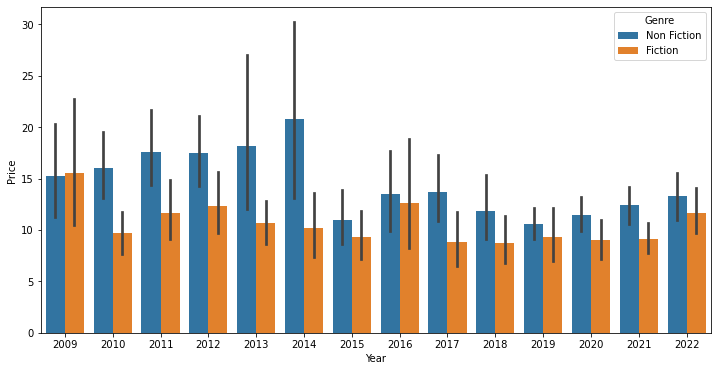

In [21]:
plt.figure(figsize=(12,6))
sb.barplot(data=book, x='Year', y='Price', hue='Genre')

Utilizzando la libreria seaborn che offre grafici molto precisi possiamo vedere come il prezzo dei libri "non fiction" è solitamente più alto rispetto a quello dei libri Fiction in ogni anno

Possiamo confermare quanto appena detto attraverso un T-test:

H0: i libri "Non Fiction" costano di più rispetto a quelli "Fiction"

H1:i libri "Non Fiction" costano di meno rispetto a quelli "Fiction"

In [22]:
t_statistic, p_value = stats.ttest_1samp(a= book['Price'][book['Genre']=="Fiction"], popmean= book['Price'][book['Genre']!="Fiction"].mean(),alternative='less')
print(t_statistic)
print(p_value)

-8.22729881310927
2.6502543689334234e-15


Dallo studio della correlazione vediamo inoltre come il prezzo non incide su il numero di reviews e user rating

## CONCLUSIONI

Dallo studio del dataset si è concluso come:
+ Il numero di reviews negli anni è salito vertiginosamente
+ in generale c'è una preferenza verso i libri Non Fiction
+ il prezzo medio dei bestseller è variato molto negli anni
+ in generale i libri Fiction hanno un prezzo superiore di alcuni euro